In [42]:
import re
import pandas as pd

# Regex pattern
pattern = re.compile(
    r'(?P<ip>\S+) - (?P<country>\S+) - \[(?P<timestamp>.*?)\] '
    r'"(?P<method>\S+) (?P<endpoint>\S+) (?P<protocol>\S+)" '
    r'(?P<status>\d{3}) (?P<bytes>\d+) "(?P<referrer>[^"]*)" "(?P<user_agent>[^"]*)" (?P<response_time>\d+)'
)

# Store parsed entries
entries = []

In [43]:
# Read log file line by line
with open('sample-log.log', 'r') as f:
    for line in f:
        match = pattern.match(line)
        if match:
            entries.append(match.groupdict())

# Convert to DataFrame
df = pd.DataFrame(entries)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y:%H:%M:%S')

print(df.head(15))
print(df.columns)

                ip country           timestamp method  \
0    100.34.17.233      NO 2025-07-01 06:00:02    GET   
1    173.80.18.254      NO 2025-07-01 06:00:04   POST   
2        10.3.0.48      SE 2025-07-01 06:00:06    GET   
3    172.56.143.33      US 2025-07-01 06:00:08    GET   
4   208.54.157.184      NO 2025-07-01 06:00:09   POST   
5     96.114.162.7      SE 2025-07-01 06:00:15    GET   
6    107.78.231.35      FR 2025-07-01 06:00:16    GET   
7     174.54.112.5      DK 2025-07-01 06:00:17    GET   
8     192.168.3.81      FR 2025-07-01 06:00:19   POST   
9   99.224.121.154      US 2025-07-01 06:00:22    GET   
10     172.21.0.92      DE 2025-07-01 06:00:23    GET   
11   100.34.131.87      DK 2025-07-01 06:00:25    GET   
12    68.1.252.104      SE 2025-07-01 06:00:27   POST   
13   174.50.109.73      DK 2025-07-01 06:00:28    GET   
14     10.12.0.218      CA 2025-07-01 06:00:31    GET   

                                         endpoint  protocol status bytes  \
0          

In [44]:
# check top IP addresses by frequency
ip_counts = df['ip'].value_counts()
ip_counts.head(15)
print(df.columns)

Index(['ip', 'country', 'timestamp', 'method', 'endpoint', 'protocol',
       'status', 'bytes', 'referrer', 'user_agent', 'response_time'],
      dtype='object')


In [47]:
# check request rate per ip
# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Group by IP and resample by 1-minute window
requests_per_minute = df.groupby('ip').resample('1T').size().unstack(fill_value=0)

# flatten result for clearer table (if needed)
avg_requests_per_ip = requests_per_minute.mean(axis=1).sort_values(ascending=False)

In [ ]:
avg_requests_per_ip.head()

ip
45.133.1.1      1.011236
45.133.1.2      1.011236
35.185.0.156    0.674157
194.168.1.2     0.348127
194.168.1.6     0.347378
dtype: float64

In [ ]:
# Resample at 5-second windows instead of 1 minute
requests_per_5s = df.groupby('ip').resample('5S').size().unstack(fill_value=0)

# Check the peak (max) request rate per IP in any 5s interval
peak_5s_rate = requests_per_5s.max(axis=1).sort_values(ascending=False)
peak_5s_rate.head(15)

/var/folders/kt/g829r7c939ncm54v0tmfl0zm0000gn/T/ipykernel_12748/2168417513.py:2: PerformanceWarning: The following operation may generate 2620038960 cells in the resulting pandas object.
  requests_per_5s = df.groupby('ip').resample('5S').size().unstack(fill_value=0)


ip
35.185.0.156      10
194.168.1.2        9
194.168.1.3        9
45.133.1.2         9
45.133.1.1         9
194.168.1.5        9
194.168.1.4        8
194.168.1.8        8
194.168.1.6        8
194.168.1.1        7
194.168.1.7        7
198.228.34.192     2
86.2.115.73        2
98.113.45.36       2
10.12.0.201        2
dtype: int64

In [ ]:
print(peak_5s_rate.mean())

1.0072394648665834


In [ ]:
suspicious_peak_5s_rate = peak_5s_rate[peak_5s_rate > 2]
suspicious_peak_5s_rate.value_counts()

9     5
8     3
7     2
10    1
Name: count, dtype: int64

In [55]:
# Number of unique endpoints per IP
unique_endpoints = df.groupby('ip')['endpoint'].nunique().sort_values(ascending=False)
unique_endpoints.head(16)

ip
35.185.0.156       2280
45.133.1.1          600
45.133.1.2          600
194.168.1.6         595
194.168.1.7         591
194.168.1.8         587
194.168.1.2         579
194.168.1.3         567
194.168.1.1         562
194.168.1.5         554
194.168.1.4         536
185.220.101.78      304
185.220.101.86      304
185.220.102.135     304
185.220.101.19      304
185.220.100.77      304
Name: endpoint, dtype: int64

In [57]:
df['ip'].nunique()

40887

In [ ]:
#average unique endpoints accessed by each IP
average_unique_endp = unique_endpoints.mean()
print(average_unique_endp)

8.431432973805855


In [ ]:
# Bots often access suspicious endpoints
suspicious_endpoints = ['/admin', '/login', '/robots.txt']
df[df['endpoint'].isin(suspicious_endpoints)].value_counts()

Series([], Name: count, dtype: int64)

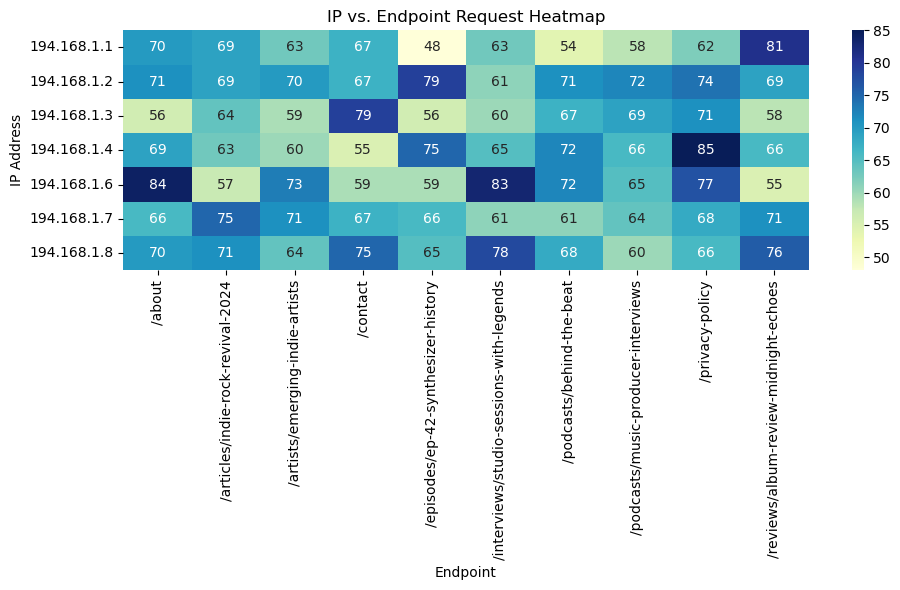

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table: rows=IP, columns=Endpoint, values=counts
top_ips = df['ip'].value_counts().head(10).index # top 10 most active IPs
top_endpoints = df['endpoint'].value_counts().head(10).index # top 10 most accessed endpoints
filtered_df = df[df['ip'].isin(top_ips) & df['endpoint'].isin(top_endpoints)]

pivot = filtered_df.pivot_table(index='ip', columns='endpoint', aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('IP vs. Endpoint Request Heatmap')
plt.xlabel('Endpoint')
plt.ylabel('IP Address')
plt.tight_layout()
plt.show()

In [ ]:
# Checking for non-human 'work hours'
df['hour'] = df.index.hour
night_activity = df[df['hour'].between(1, 5)]
night_activity['ip'].value_counts()

ip
35.185.0.156    3600
Name: count, dtype: int64

Index(['ip', 'country', 'timestamp', 'method', 'endpoint', 'protocol',
       'status', 'bytes', 'referrer', 'user_agent', 'response_time'],
      dtype='object')


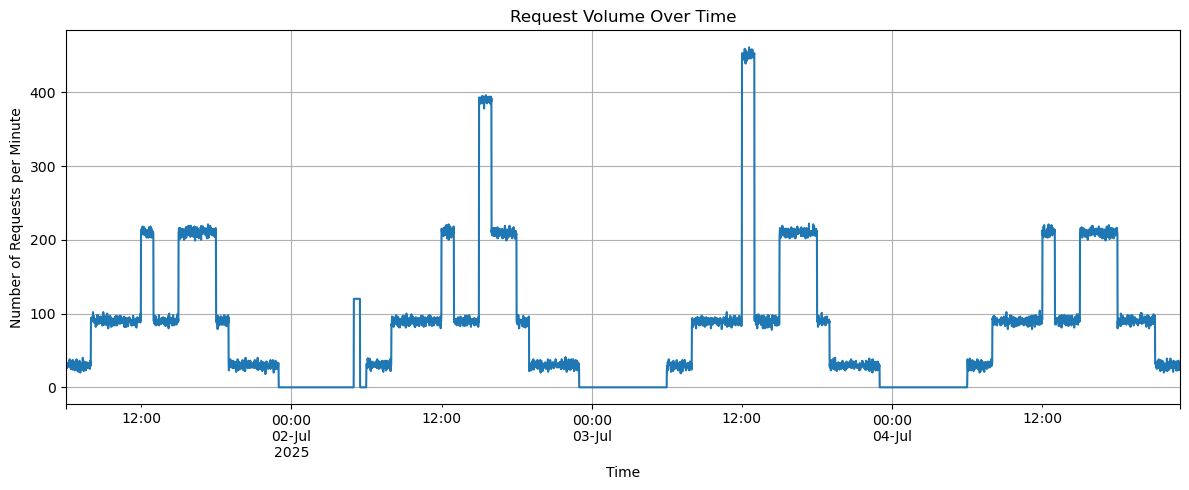

In [ ]:
# Time series plot with request volume
# Optional: sort just in case
df = df.sort_values('timestamp')
# Group requests by time interval (e.g., per minute)
requests_over_time = df.set_index('timestamp').resample('1T').size()

# Plot the time series
plt.figure(figsize=(12, 5))
requests_over_time.plot()
plt.title("Request Volume Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Requests per Minute")
plt.grid(True)
plt.tight_layout()
plt.show()